(Copied from argmax)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from pynq import allocate

In [2]:
from pynq import PL
PL.reset()
import xrfdc

In [3]:
from pynq import Overlay
ol = Overlay('./auto_trigger.bit')

In [4]:
# sanity check that we are at 150 MHz
from pynq import Clocks
print(Clocks.fclk0_mhz)
Clocks.fclk0_mhz = 150
print(Clocks.fclk0_mhz)

214.283571
149.9985


In [5]:
rf = ol.usp_rf_data_converter_0
adc_tile = rf.adc_tiles[2]
adc_block = adc_tile.blocks[0]
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
center_frequency = 1575.43
doppler = 0
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'Freq': 1575.429999999993, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [6]:
N = 4096
num_width = 32

In [7]:
mmio_interface = ol.mmio_interface
dma_out_argmax = ol.axi_dma_0
dma_out_conv = ol.axi_dma_1
dma_prn_config = ol.axi_prn_config
dma_iq_config = ol.axi_iq_config
dma_ifft_config = ol.axi_ifft_config

In [8]:
# set up ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1
# note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
dma_ifft_config.sendchannel.transfer(ifft_config)
dma_ifft_config.sendchannel.wait()

In [9]:
# numerical helpers
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [10]:
res_data = allocate(2*N, dtype=np.uint32)
def get_conv_data(): #outputs 1 code block
    #mmio_interface.write(0x08, 0)
    #time.sleep(0.001)
    mmio_interface.write(0x08, 1)
    dma_out_conv.recvchannel.transfer(res_data)
    dma_out_conv.recvchannel.wait()
    return res_data

In [19]:
def doppler_sweep(prn_id, start = -8000, end = 8000, step = 100, scaling = 16): #sweeps frequency range
    doppler_range = list(range(start, end, step))
    mmio_interface.write(0x00, scaling)
    mmio_interface.write(0x04, prn_id-1)

    amplitudes = []
    for doppler in doppler_range:
        
#         if doppler % 1000 == 0: print(f'on doppler {doppler}')
            
        # set adc frequency now
        adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
        adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
        
        res_data = get_conv_data()

        # now do calculation
        real = res_data[1::2]
        imag = res_data[0::2]
        real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
        imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]
        convolve = np.array([x+y*1j for (x,y) in zip(real_decimal, imag_decimal)])
        peak_position = np.argmax(abs(convolve))
        amplitudes.append(abs(convolve)[peak_position]**2)

    plt.plot(doppler_range, amplitudes)
    best_doppler = np.argmax(amplitudes)
    return amplitudes

[31677818.000000004,
 29494844.999999993,
 26755490.000000004,
 27292625.0,
 28483930.000000007,
 42457159.99999999,
 25199369.000000007,
 25523144.0,
 28960353.0,
 27725890.000000004,
 25965028.000000004,
 33433866.000000007,
 27878500.99999999,
 24696144.999999996,
 28927384.999999993,
 25072165.000000007,
 30708529.0,
 26125481.0,
 24373925.000000004,
 22243700.0,
 33294273.999999993,
 24618980.000000004,
 25929305.999999996,
 29677141.0,
 33792100.00000001,
 26563059.999999996,
 28208533.0,
 24807429.0,
 48394025.000000015,
 25056929.000000004,
 26276728.999999996,
 32631901.000000004,
 29349325.0,
 29173849.999999996,
 29503665.0,
 31718480.000000004,
 27569425.999999993,
 22724936.000000004,
 27252965.0,
 27247251.999999996,
 26379400.000000004,
 33814978.0,
 26395658.000000007,
 31146111.99999999,
 30388360.999999996,
 30301954.000000007,
 26464778.0,
 33209005.000000004,
 28430356.0,
 30966307.999999996,
 32128018.000000004,
 28729490.0,
 33661394.0,
 27429625.0,
 25094595.9999

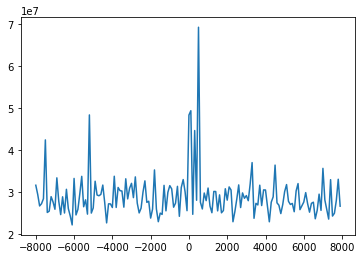

In [20]:
doppler_sweep(30)

In [12]:
def prn_sweep(start = -5000, end = 5000, step = 100, scaling = 16): #sweeps all 37 prns
    full_data = []
    for i in range(1,38):
        amplitudes = doppler_sweep(i,start=start, end=end, step=step, scaling=scaling)
        full_data.append(amplitudes)
        print(f"Frequency sweep of prn ID {i}, max {max(amplitudes)}")        
    return full_data

In [13]:
def test_shift(doppler_shift, prn_id):
    mmio_interface.write(0x04, prn_id-1)
    
    #doppler_shift = 2200
    adc_block.MixerSettings['Freq']= center_frequency + doppler_shift / 1e6 # set the frequency of the Numerically controlled oscillator.
    adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
    
    argmax_data = allocate(2*1000, np.int32)
    dma_out_argmax.recvchannel.transfer(argmax_data)
    for i in range(1000):
        #print(f"on sample {i}")
        get_conv_data()
        dma_out_conv.sendchannel.transfer(res_data)
        dma_out_conv.sendchannel.wait()
    #     print(res_data)
    # ok, 1000 are done, we expect an output at dma_out_argmax
    dma_out_argmax.recvchannel.wait()
    
    indices = argmax_data[0::2]
    values = argmax_data[1::2]
    real = get_components(values,16)["real"]
    imag = get_components(values,16)["imag"]
    mag = [abs(real[i]+imag[i]*1j) for i in range(1000)]
    
    #plt.plot(list(range(0,50)), imag[:50])
    #plt.plot(list(range(0,50)), real[:50])
    
    return(sum(mag))

In [14]:
def collect(doppler_shift, prn_id):
    mmio_interface.write(0x04, prn_id-1)
    
    adc_block.MixerSettings['Freq']= center_frequency + doppler_shift / 1e6 # set the frequency of the Numerically controlled oscillator.
    adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
    
    argmax_data = allocate(2*1000, np.int32)
    dma_out_argmax.recvchannel.transfer(argmax_data)
    for i in range(1000):
        #print(f"on sample {i}")
        get_conv_data()
        dma_out_conv.sendchannel.transfer(res_data)
        dma_out_conv.sendchannel.wait()
    #     print(res_data)
    # ok, 1000 are done, we expect an output at dma_out_argmax
    dma_out_argmax.recvchannel.wait()
    
    indices = argmax_data[0::2]
    values = argmax_data[1::2]
    real = get_components(values,16)["real"]
    imag = get_components(values,16)["imag"]
    mag = [abs(real[i]+imag[i]*1j) for i in range(1000)]
    
    #plt.plot(list(range(0,50)), imag[:50])
    #plt.plot(list(range(0,50)), real[:50])
    
    return(real, imag, indices)

In [15]:
# set scaling
mmio_interface.write(0x00, 16)

# set prn
mmio_interface.write(0x04, 26)

# set center_frequency
doppler_shift = 2000
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.



In [16]:
argmax_data = allocate(2*1000, np.int32)

In [17]:
import time
start_time = time.time()

dma_out_argmax.recvchannel.transfer(argmax_data)
for i in range(1000):
    get_conv_data()
    dma_out_conv.sendchannel.transfer(res_data)
    dma_out_conv.sendchannel.wait()
    print(f"got sample {i}, time since start {time.time()-start_time}")
#     print(res_data)
# ok, 1000 are done, we expect an output at dma_out_argmax
dma_out_argmax.recvchannel.wait()

got sample 0, time since start 0.0030553340911865234
got sample 1, time since start 0.003943204879760742
got sample 2, time since start 0.004958629608154297
got sample 3, time since start 0.0059435367584228516
got sample 4, time since start 0.006930828094482422
got sample 5, time since start 0.007941961288452148
got sample 6, time since start 0.009216785430908203
got sample 7, time since start 0.010230779647827148
got sample 8, time since start 0.01141810417175293
got sample 9, time since start 0.011996030807495117
got sample 10, time since start 0.013000249862670898
got sample 11, time since start 0.014564752578735352
got sample 12, time since start 0.015052080154418945
got sample 13, time since start 0.01707148551940918
got sample 14, time since start 0.017835617065429688
got sample 15, time since start 0.018281221389770508
got sample 16, time since start 0.018944978713989258
got sample 17, time since start 0.019934892654418945
got sample 18, time since start 0.02096390724182129
got 

got sample 218, time since start 0.2222888469696045
got sample 219, time since start 0.2229156494140625
got sample 220, time since start 0.22333574295043945
got sample 221, time since start 0.22393012046813965
got sample 222, time since start 0.2249617576599121
got sample 223, time since start 0.22592616081237793
got sample 224, time since start 0.22693896293640137
got sample 225, time since start 0.22792601585388184
got sample 226, time since start 0.22894763946533203
got sample 227, time since start 0.22993898391723633
got sample 228, time since start 0.2309281826019287
got sample 229, time since start 0.23193740844726562
got sample 230, time since start 0.23352575302124023
got sample 231, time since start 0.2339487075805664
got sample 232, time since start 0.2349393367767334
got sample 233, time since start 0.23592543601989746
got sample 234, time since start 0.23695135116577148
got sample 235, time since start 0.23794150352478027
got sample 236, time since start 0.23892569541931152

got sample 442, time since start 0.4462740421295166
got sample 443, time since start 0.44690442085266113
got sample 444, time since start 0.4473252296447754
got sample 445, time since start 0.447951078414917
got sample 446, time since start 0.44895291328430176
got sample 447, time since start 0.4499340057373047
got sample 448, time since start 0.45094776153564453
got sample 449, time since start 0.4519531726837158
got sample 450, time since start 0.45351552963256836
got sample 451, time since start 0.45394229888916016
got sample 452, time since start 0.4549291133880615
got sample 453, time since start 0.4559321403503418
got sample 454, time since start 0.4569532871246338
got sample 455, time since start 0.4579317569732666
got sample 456, time since start 0.45894503593444824
got sample 457, time since start 0.45995140075683594
got sample 458, time since start 0.46094584465026855
got sample 459, time since start 0.46195125579833984
got sample 460, time since start 0.4629373550415039
got 

got sample 671, time since start 0.67521071434021
got sample 672, time since start 0.6758241653442383
got sample 673, time since start 0.6768207550048828
got sample 674, time since start 0.6772377490997314
got sample 675, time since start 0.6781406402587891
got sample 676, time since start 0.6789743900299072
got sample 677, time since start 0.6807956695556641
got sample 678, time since start 0.681239128112793
got sample 679, time since start 0.6819403171539307
got sample 680, time since start 0.6829245090484619
got sample 681, time since start 0.6839251518249512
got sample 682, time since start 0.684978723526001
got sample 683, time since start 0.6859524250030518
got sample 684, time since start 0.6869347095489502
got sample 685, time since start 0.6879236698150635
got sample 686, time since start 0.6889374256134033
got sample 687, time since start 0.6899271011352539
got sample 688, time since start 0.6909236907958984
got sample 689, time since start 0.6919379234313965
got sample 690, 

got sample 874, time since start 0.8781518936157227
got sample 875, time since start 0.8787736892700195
got sample 876, time since start 0.8791882991790771
got sample 877, time since start 0.8799357414245605
got sample 878, time since start 0.8815231323242188
got sample 879, time since start 0.8819456100463867
got sample 880, time since start 0.8831543922424316
got sample 881, time since start 0.8839676380157471
got sample 882, time since start 0.8857882022857666
got sample 883, time since start 0.8862347602844238
got sample 884, time since start 0.8869266510009766
got sample 885, time since start 0.8879306316375732
got sample 886, time since start 0.8889753818511963
got sample 887, time since start 0.8899354934692383
got sample 888, time since start 0.8909397125244141
got sample 889, time since start 0.8919343948364258
got sample 890, time since start 0.8929564952850342
got sample 891, time since start 0.8939220905303955
got sample 892, time since start 0.8949415683746338
got sample 8

In [18]:
indices = argmax_data[0::2]
values = argmax_data[1::2]
real = get_components(values,16)["real"]
imag = get_components(values,16)["imag"]
mag = [abs(real[i]+imag[i]*1j) for i in range(1000)]


In [19]:
sum(mag)

5297032.584143541

(array([101., 175., 128.,  76.,  36.,  35.,  90., 161., 180.,  18.]),
 array([-5966. , -4719.2, -3472.4, -2225.6,  -978.8,   268. ,  1514.8,
         2761.6,  4008.4,  5255.2,  6502. ]),
 <BarContainer object of 10 artists>)

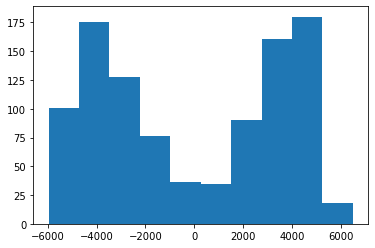

In [20]:
plt.hist(imag)

(array([ 93., 188., 126.,  56.,  31.,  35.,  76., 137., 180.,  78.]),
 array([-6017. , -4809.2, -3601.4, -2393.6, -1185.8,    22. ,  1229.8,
         2437.6,  3645.4,  4853.2,  6061. ]),
 <BarContainer object of 10 artists>)

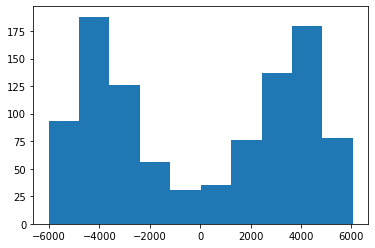

In [21]:
plt.hist(real)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   2., 541., 409.,  47.]),
 array([   0.        ,  661.31295163, 1322.62590327, 1983.9388549 ,
        2645.25180654, 3306.56475817, 3967.87770981, 4629.19066144,
        5290.50361308, 5951.81656471, 6613.12951635]),
 <BarContainer object of 10 artists>)

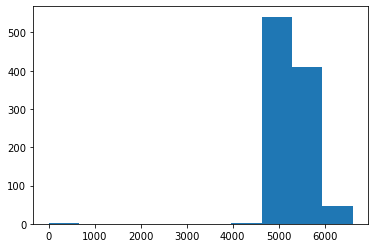

In [22]:
plt.hist(mag)

(array([ 98., 110.,  97.,  92.,  95., 109.,  95., 112.,  93.,  99.]),
 PynqBuffer([   0. ,  409.4,  818.8, 1228.2, 1637.6, 2047. , 2456.4,
             2865.8, 3275.2, 3684.6, 4094. ]),
 <BarContainer object of 10 artists>)

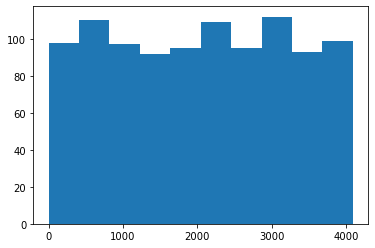

In [23]:
plt.hist(indices)

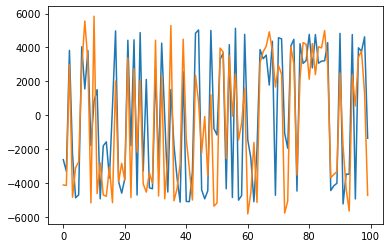

In [24]:
plt.plot(list(range(0,100)), imag[:100])
plt.plot(list(range(0,100)), real[:100])

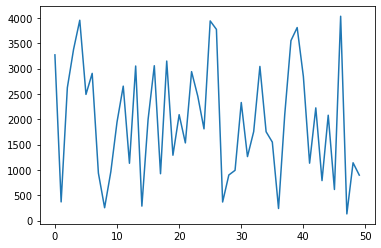

In [25]:
plt.plot(list(range(0,50)), indices[200:250])

In [26]:
for shift in range(-750,-550,10):
    print(shift, test_shift(shift, 27))

-750 5284573.337713504
-740 5309698.722010404
-730 5303197.953387188
-720 5311457.488769152
-710 5320165.0305000935
-700 5317801.970500393
-690 5298795.917103431
-680 5304262.938180834
-670 5305730.1617112225
-660 5285555.155381631
-650 5297809.667291336
-640 5299117.6983045135
-630 5281677.883019819
-620 5308641.6716017015
-610 5313408.5908206
-600 5299396.918724499
-590 5302716.91533122
-580 5304880.988557574
-570 5297486.8968767235
-560 5297888.322291443


In [27]:
real, imag, indices = collect(-1680,27)
phase_shift = np.array([np.angle(real[i]+imag[i]*1j) for i in range(1000)])

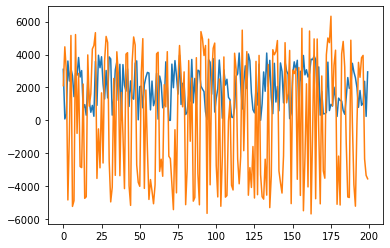

In [28]:
base_index = 400
number = 200
plt.plot(list(range(0,number)), indices[base_index:base_index+number])
plt.plot(list(range(0,number)), real[base_index:base_index+number])

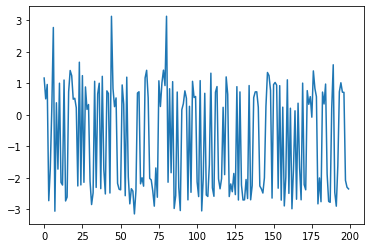

In [29]:
plt.plot(list(range(0,number)), phase_shift[base_index:base_index+number])

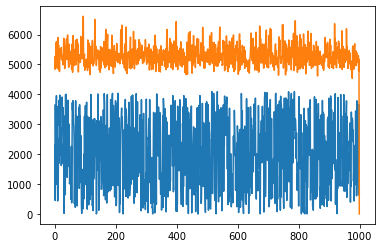

In [30]:
plt.plot(list(range(0,1000)), indices)
plt.plot(list(range(0,1000)), mag)

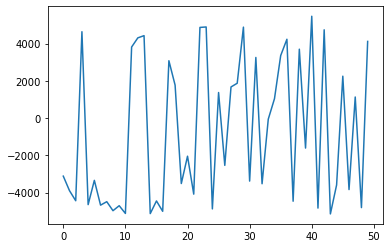

In [31]:
plt.plot(list(range(0,50)), real[200:250])

In [32]:
import statistics
def bpsk_filter(phase_shift, indices, downsample = 5):
    #only take data that is close to the index
    #we down sample by 5? for now
    filtered = []
    for i in range(0,1000,downsample):
        subphase = list(phase_shift[i:min(1000,i+downsample)])
        subindices = list(indices[i:min(1000,i+downsample)])
        indexmode = statistics.mode(subindices)
        location = subindices.index(indexmode)
        chosenphase = subphase[location]
        filtered.append(chosenphase)
        print(i,indexmode,chosenphase)
    return(filtered)
    
filtered = bpsk_filter(phase_shift, indices)

0 3637 -2.6863411529154178
5 3957 0.7678750178370598
10 574 1.329325102623318
15 2948 -2.3928687883783857
20 2875 -2.537279877670467
25 3031 0.4862961244451111
30 19 -1.9733853107633732
35 3998 -3.1306252272712802
40 1225 0.7072942043745652
45 2911 -2.2025591632998056
50 1203 0.09799378752318585
55 369 0.9186952043202824
60 3501 0.830293978771464
65 1090 0.6822699717471906
70 2893 -1.9259097742540712
75 2813 -2.267369601686092
80 852 -2.7388774807827847
85 2622 -2.667431519167181
90 1460 0.8823623098099601
95 1997 -2.210489723888998
100 3623 1.3073663731413534
105 936 -2.447042656986064
110 1197 -2.3340495854271017
115 479 0.48699865515554275
120 3130 0.7097787141554098
125 110 0.5793476566935495
130 3194 1.057292771028731
135 1537 1.1472405205179852
140 1475 0.2728421857585533
145 2836 -1.8457980302251724
150 1953 -2.0748029908830956
155 1216 -2.600788820156203
160 610 0.5856138663347638
165 985 0.9869075156048105
170 364 -2.27298814565912
175 897 0.818061008372081
180 1589 -3.0176789

In [35]:
# convolve at current doppler
# convolve with doppler before and doppler after (5Hz)
# adjust in the correct dir
# output the correct convolution
# graph the doppler over time

In [33]:
#testing how fast the code delay shifts
#print(statistics.mode(indices[0:10]))
#print(statistics.mode(indices[10:20]))
#print(statistics.mode(indices[90:95]))
#print(statistics.mode(indices[910:915]))

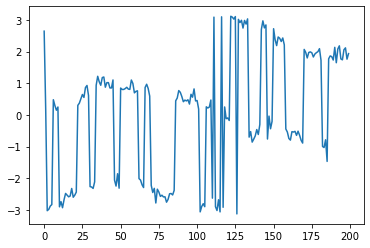

In [486]:
plt.plot(list(range(0,200)), filtered)
plt.savefig('bpsk-2.png')

In [494]:
with open("filtered-data", "w") as z:
    for i in filtered:
        z.write(str(i))
        z.write("\n")

In [485]:
np.pi % (2* np.pi)

3.141592653589793

TypeError: 'int' object is not callable